In [4]:
from pyprojroot import here
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max, blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage.restoration import denoise_tv_chambolle
from skimage.feature import blob_dog, blob_log
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import csv
import pprint

# Set a dark theme for the plot
plt.style.use('dark_background')

root = here()

In [5]:
data_path = root / "Microscopy/train"
raw_metadata_path = root / "Microscopy/train/meta.csv"

data_list = []
data_lists = {}

# open 10 images from meta.csv and display them
with open(raw_metadata_path, 'r') as f:
    # Create a csv reader object
    csv_reader = csv.reader(f)
    
    # Skip the header row
    next(csv_reader)

    for row in csv_reader:
        data_list.append(row)

        dose_Gy = float(row[1])
        particle_type = row[2]
        hr_post_exposure = int(row[3])

        if not (dose_Gy, hr_post_exposure, particle_type) in data_lists:
            data_lists[(dose_Gy, hr_post_exposure, particle_type)] = []
            
        data_lists[(dose_Gy, hr_post_exposure, particle_type)].append(row[0])

In [6]:
for key in data_lists:
    print(key, len(data_lists[key]))

(0.82, 4, 'Fe') 4416
(0.3, 4, 'Fe') 4582
(0.0, 4, 'Fe') 4632
(0.82, 24, 'Fe') 4515
(0.3, 24, 'Fe') 4668
(0.0, 24, 'Fe') 4651
(0.82, 48, 'Fe') 4593
(0.0, 48, 'Fe') 4507
(0.0, 4, 'X-ray') 4803
(0.1, 4, 'X-ray') 4726
(1.0, 4, 'X-ray') 4450
(0.0, 24, 'X-ray') 4437
(0.1, 24, 'X-ray') 4408
(1.0, 24, 'X-ray') 4519
(0.0, 48, 'X-ray') 4448
(0.1, 48, 'X-ray') 4451
(1.0, 48, 'X-ray') 4371


In [20]:
def count_foci_watershed(img_key):
    # Load the image using PIL
    img = Image.open(img_key)
    img_array = np.array(img)

    # Normalize the pixel values to the range of 0-255
    image_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))

    # Denoise the normalized image using TVD algorithm
    denoised_array = denoise_tv_chambolle(image_normalized, weight=0.1)

    # Convert the denoised array back to PIL Image and adjust back to 8-bit range
    denoised_image = Image.fromarray(img_as_ubyte(denoised_array))

    # Apply a sharpening filter
    sharpened_image = denoised_image.filter(ImageFilter.UnsharpMask(radius=5, percent=500, threshold=50))
    sharpened_image = np.array(sharpened_image)

    # Denoise the sharpened image using TVD algorithm
    denoised_array = denoise_tv_chambolle(sharpened_image, weight=0.1)
    denoised_image = Image.fromarray(denoised_array)
    denoised_image = np.array(denoised_image)

    # Apply a threshold to segment the image
    threshold_value = 175  # Adjust this threshold value as needed
    binary_image = denoised_image*255 > threshold_value

    # Apply distance transformation to find the distance of each pixel to the nearest background pixel
    distance_transform = ndi.distance_transform_edt(binary_image)

    # Identify the local maxima in the distance transformed image as markers for watershed segmentation
    coordinates = peak_local_max(distance_transform, min_distance=5, threshold_abs=0.8)
    mask = np.zeros(distance_transform.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)

    # Perform watershed segmentation
    segmentation = watershed(-distance_transform, markers, mask=binary_image)

    # Count the number of foci (regions) detected
    num_foci = 0

    # Get region properties of the segmented regions
    regions = regionprops(segmentation)

    # Draw bounding boxes around the foci
    margin = 10

    for region in regions:
        minr, minc, maxr, maxc = region.bbox

        # Add margin around the bounding box
        minr = max(0, minr - margin)
        minc = max(0, minc - margin)
        maxr = min(segmentation.shape[0], maxr + margin)
        maxc = min(segmentation.shape[1], maxc + margin)

        # Only draw the bounding boxes for the foci that are larger than 35 pixels
        if (maxr - minr <= 35) and (maxc - minc <= 35):
            num_foci += 1
    
    return num_foci

In [21]:
foci_count = {}

# Get the average number of foci for each condition
for key in data_lists:
    # Get the number of foci for first 100 images
    for img_key in data_lists[key][:200]:
        num_foci = count_foci_watershed(data_path / img_key)
        if key not in foci_count:
            foci_count[key] = []
        foci_count[key].append(num_foci)

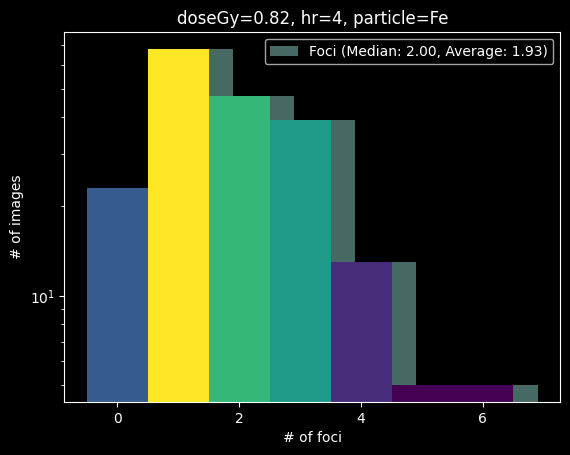

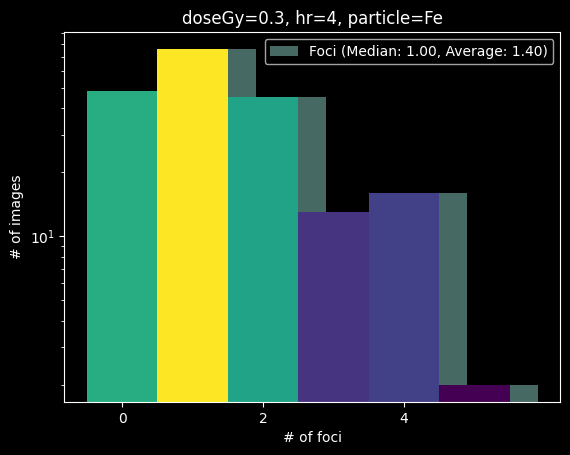

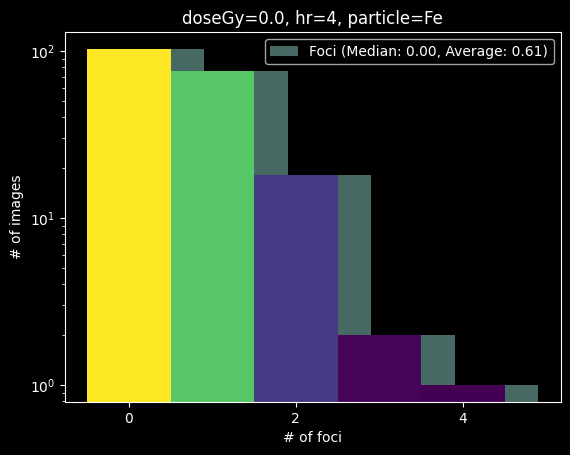

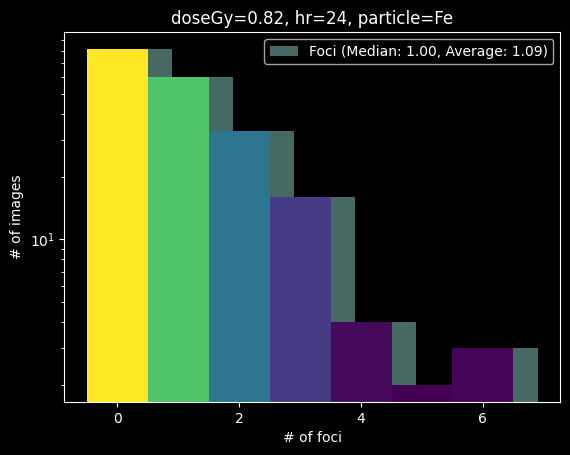

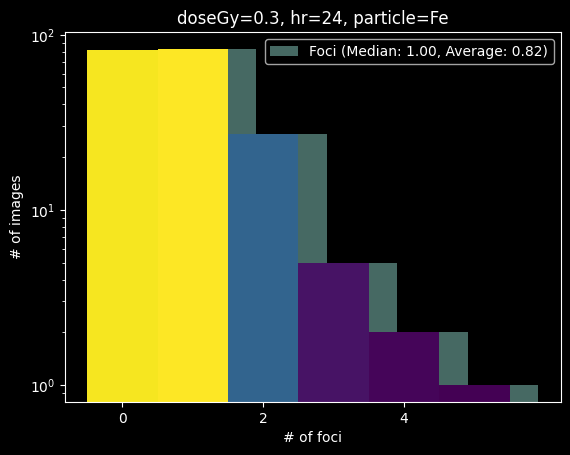

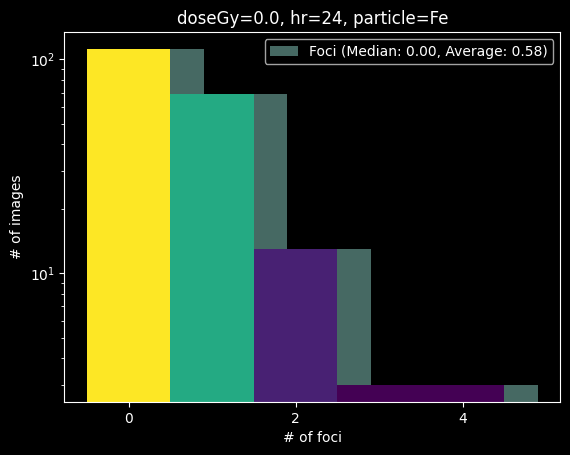

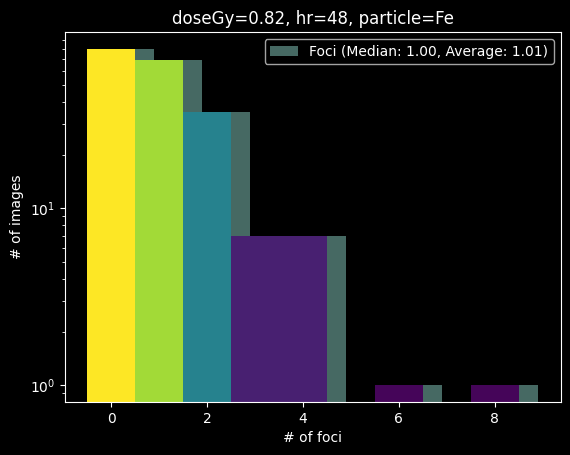

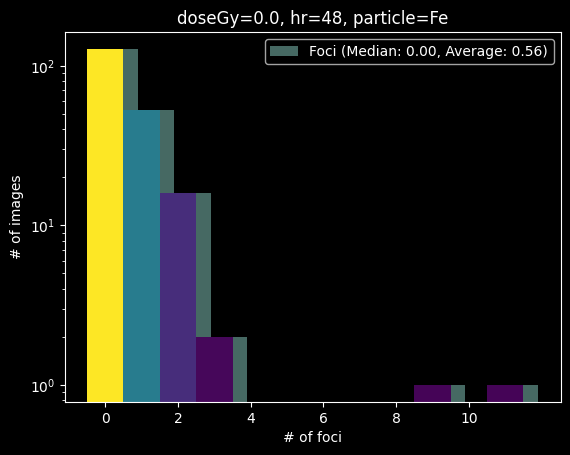

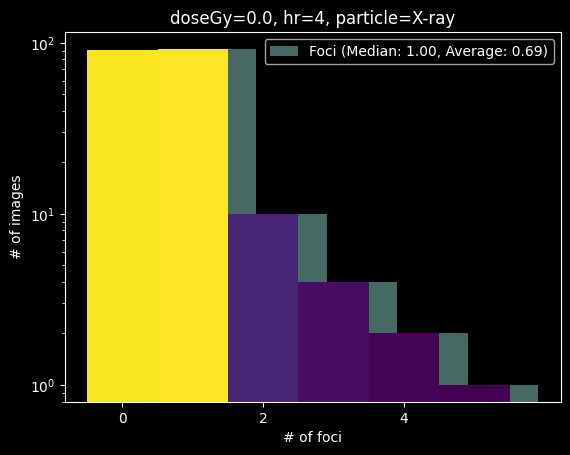

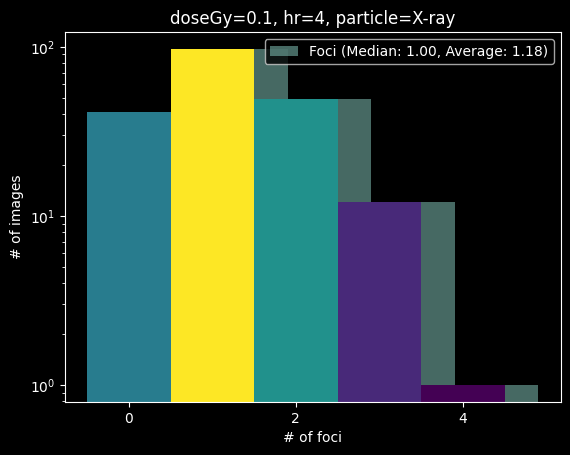

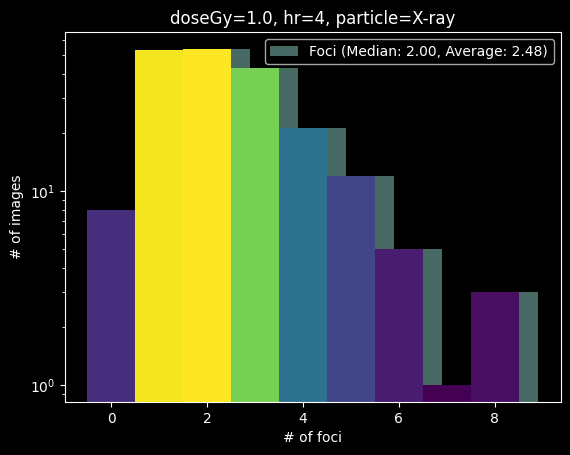

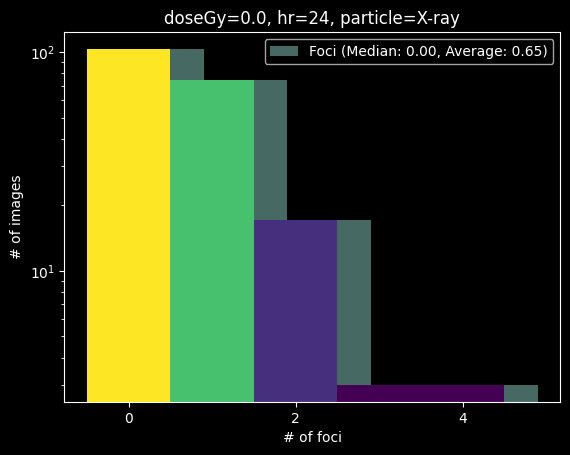

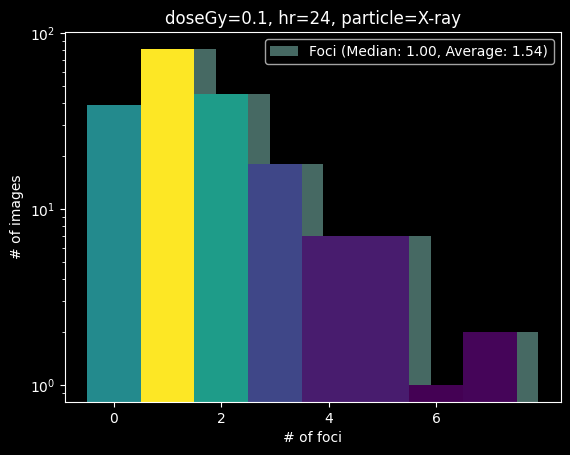

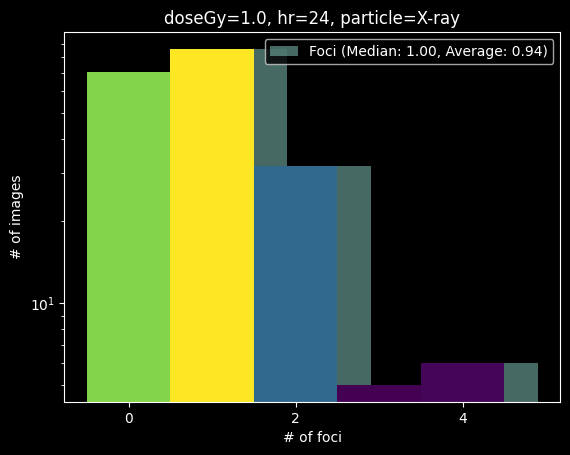

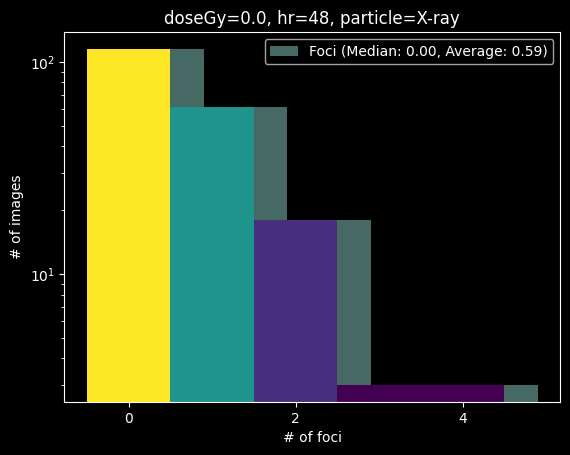

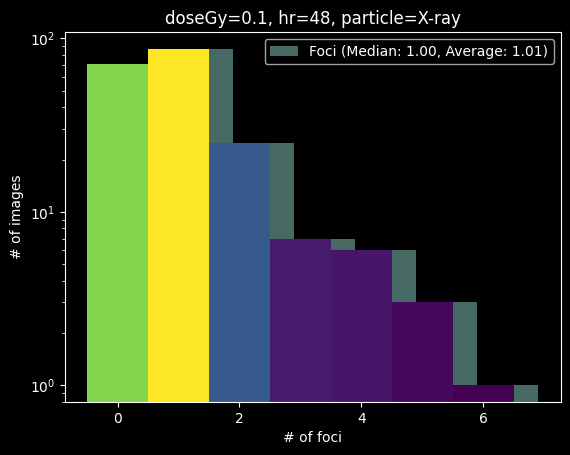

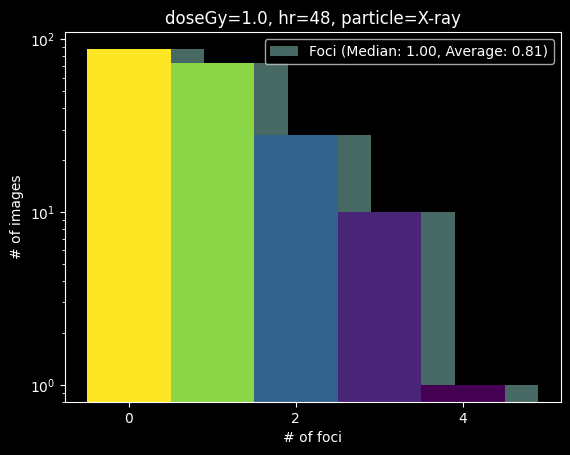

In [23]:
# Create histogram for each condition
for key in foci_count:
    heights, bins, _ = plt.hist(foci_count[key], bins=range(min(foci_count[key]), max(foci_count[key]) + 2), alpha=0.5, label="Foci", rwidth=0.8)

    # Create a colormap
    colormap = plt.cm.viridis

    # Normalize the heights to range from 0 to 1
    norm = plt.Normalize(vmin=heights.min(), vmax=heights.max())

    # Create a list of colors based on the normalized heights
    colors = [colormap(norm(height)) for height in heights]

    # Plot the histogram with colored bars
    plt.bar(bins[:-1], heights, color=colors, width=np.diff(bins))
    
    plt.xticks(range(min(foci_count[key]), max(foci_count[key]) + 1, 2))
    plt.xlabel("# of foci")
    plt.ylabel("# of images")

    # Adjust y-axis scale to logarithmic
    plt.yscale('log')
    
    # Calculate median and average
    median_val = np.median(foci_count[key])
    average_val = np.mean(foci_count[key])

    # Create custom legend labels with median and average information
    legend_label = f"Foci (Median: {median_val:.2f}, Average: {average_val:.2f})"
    plt.legend([legend_label], loc="upper right") 

    # Split key by comma
    key = str(key).split(", ")
    dose = key[0][1:]
    hr = key[1]
    particle = key[2][1:-2]
    fileName = f"dose_{dose}hr_{hr}particle_{particle}"

    plt.title(f"doseGy={dose}, hr={hr}, particle={particle}")

    # Save plots into notebooks/foci_count
    plt.savefig(str(root / "notebooks/foci_count_watershed" / fileName) + ".png")
    plt.show()
    plt.close()
    

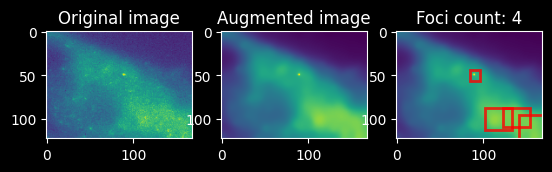

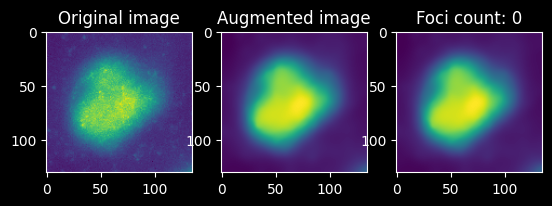

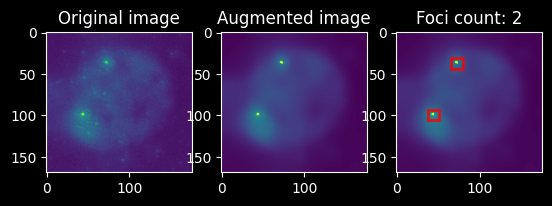

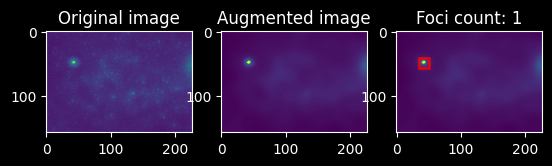

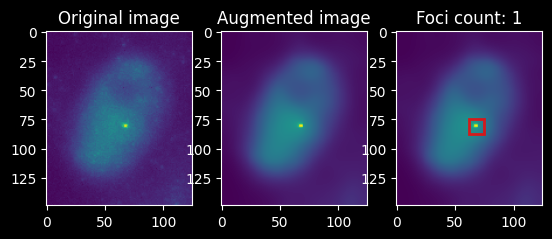

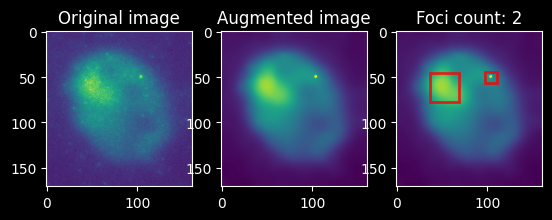

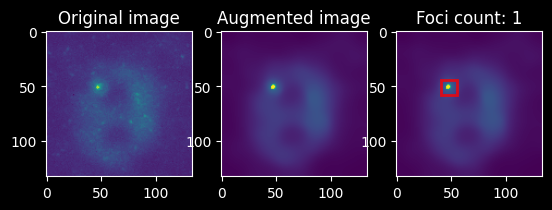

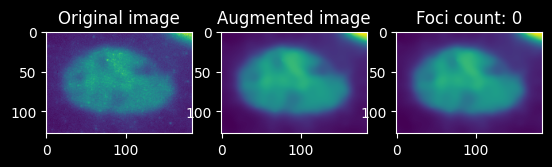

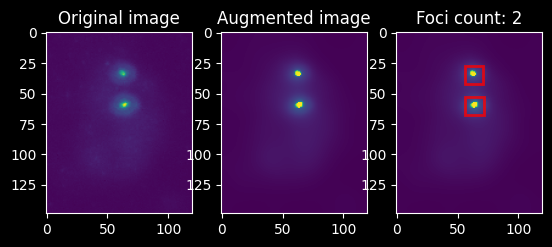

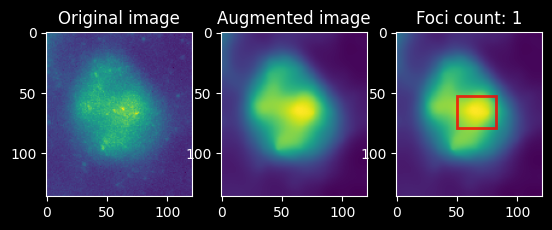

In [19]:
for i in range(10):
    img_key = data_path / data_lists[(1.0, 24, 'X-ray')][i]

    # Load the image using PIL
    img = Image.open(img_key)
    img_array = np.array(img)

    # Normalize the pixel values to the range of 0-255
    image_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))

    # Denoise the normalized image using TVD algorithm
    denoised_array = denoise_tv_chambolle(image_normalized, weight=0.1)

    # Convert the denoised array back to PIL Image and adjust back to 8-bit range
    denoised_image = Image.fromarray(img_as_ubyte(denoised_array))

    # Apply a sharpening filter
    sharpened_image = denoised_image.filter(ImageFilter.UnsharpMask(radius=5, percent=500, threshold=50))
    sharpened_image = np.array(sharpened_image)

    # Denoise the sharpened image using TVD algorithm
    denoised_array = denoise_tv_chambolle(sharpened_image, weight=0.1)
    denoised_image = Image.fromarray(denoised_array)
    denoised_image = np.array(denoised_image)

    # Apply a threshold to segment the image
    threshold_value = 175  # Adjust this threshold value as needed
    binary_image = denoised_image*255 > threshold_value

    # Apply distance transformation to find the distance of each pixel to the nearest background pixel
    distance_transform = ndi.distance_transform_edt(binary_image)

    # Identify the local maxima in the distance transformed image as markers for watershed segmentation
    coordinates = peak_local_max(distance_transform, min_distance=5, threshold_abs=0.8)
    mask = np.zeros(distance_transform.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)

    # Perform watershed segmentation
    segmentation = watershed(-distance_transform, markers, mask=binary_image)

    # Count the number of foci (regions) detected
    num_foci = 0

    # Get region properties of the segmented regions
    regions = regionprops(segmentation)

    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # Draw bounding boxes around the foci
    margin = 10

    for region in regions:
        minr, minc, maxr, maxc = region.bbox

        # Add margin around the bounding box
        minr = max(0, minr - margin)
        minc = max(0, minc - margin)
        maxr = min(segmentation.shape[0], maxr + margin)
        maxc = min(segmentation.shape[1], maxc + margin)

        # Only draw the bounding boxes for the foci that are larger than 35 pixels
        if (maxr - minr <= 35) and (maxc - minc <= 35):
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='r', linewidth=2, alpha=0.8)
            plt.gca().add_patch(rect)
            num_foci += 1

    # Display images
    ax1.imshow(img)
    ax1.title.set_text('Original image')
    ax2.imshow(denoised_image)
    ax2.title.set_text('Augmented image')
    ax3.imshow(denoised_image)
    ax3.title.set_text('Foci count: ' + str(num_foci))

    # Export figure to notebooks/foci_count
    plt.savefig(str(root / "notebooks/foci_count_watershed" / f"sample_{i}") + ".png")
    plt.show()

In [22]:
def count_foci_blob(img_key):
    # Load the image using PIL
    img = Image.open(img_key)
    img_array = np.array(img)

    # Normalize the pixel values to the range of 0-255
    image_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))

    # Denoise the normalized image using TVD algorithm
    denoised_array = denoise_tv_chambolle(image_normalized, weight=0.1)

    # Convert the denoised array back to PIL Image and adjust back to 8-bit range
    denoised_image = Image.fromarray(img_as_ubyte(denoised_array))

    # Apply a sharpening filter
    sharpened_image = denoised_image.filter(ImageFilter.UnsharpMask(radius=20, percent=200, threshold=90))
    sharpened_image = np.array(sharpened_image)

    # Denoise the sharpened image using TVD algorithm
    denoised_array = denoise_tv_chambolle(sharpened_image, weight=0.1)
    denoised_image = Image.fromarray(denoised_array)
    denoised_image = np.array(denoised_image)

    blobs = blob_dog(denoised_image, max_sigma=3.5, min_sigma=1, threshold=0.1, threshold_rel=0.8, overlap=0.5, exclude_border=20)

    # Compute radii in the 3rd column.
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2) + 5

    for blob in blobs:
        y, x, area = blob
        ax2.add_patch(plt.Circle((x, y), area, color='r', fill=False))
    
    return len(blobs)

In [25]:
foci_count = {}

# Get the average number of foci for each condition
for key in data_lists:
    # Get the number of foci for first 100 images
    for img_key in data_lists[key][:200]:
        num_foci = count_foci_blob(data_path / img_key)
        if key not in foci_count:
            foci_count[key] = []
        foci_count[key].append(num_foci)

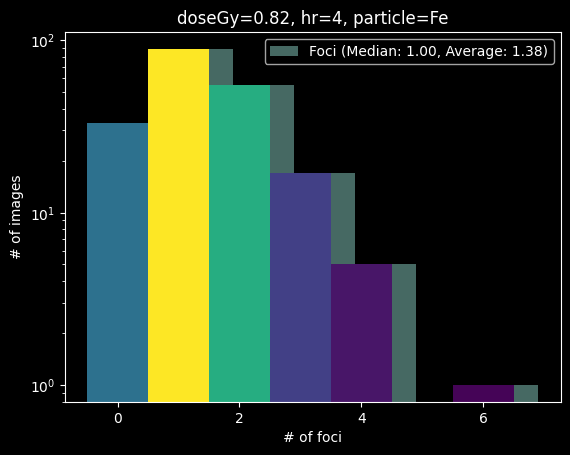

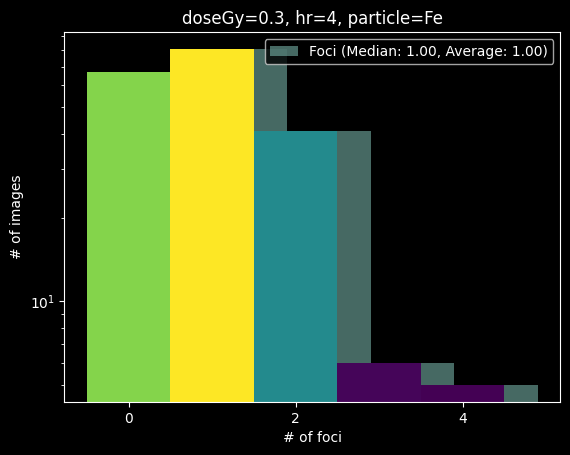

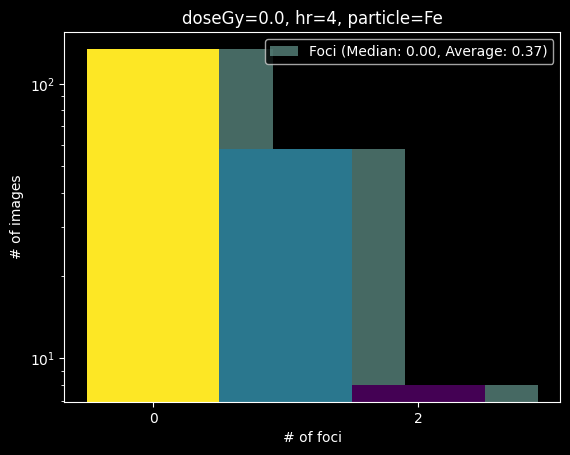

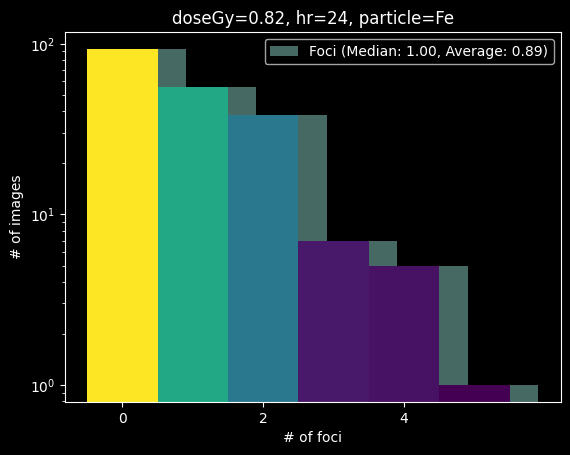

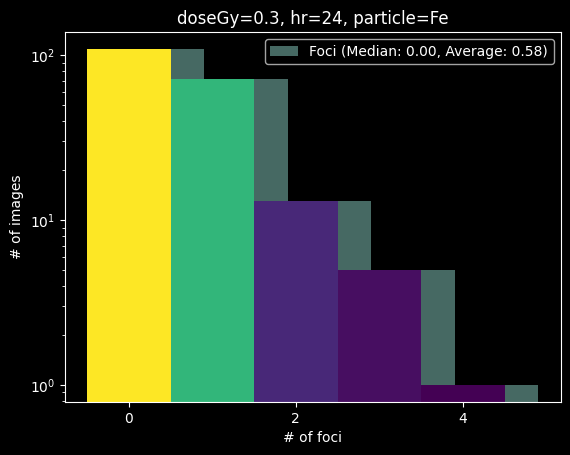

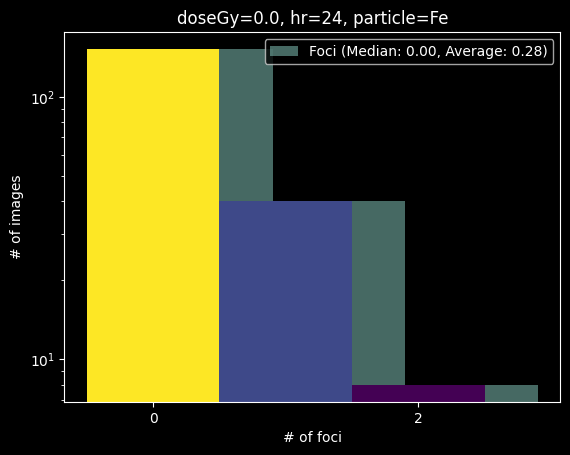

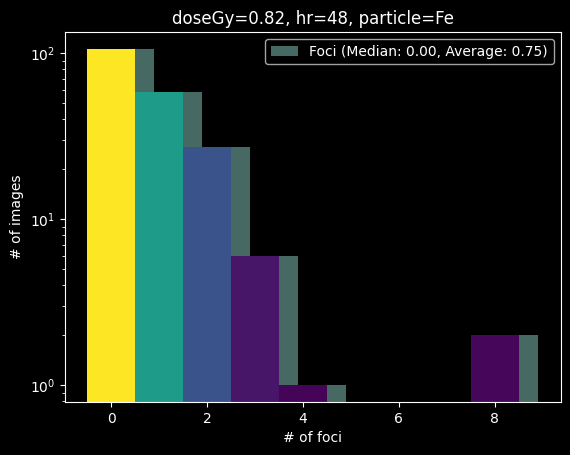

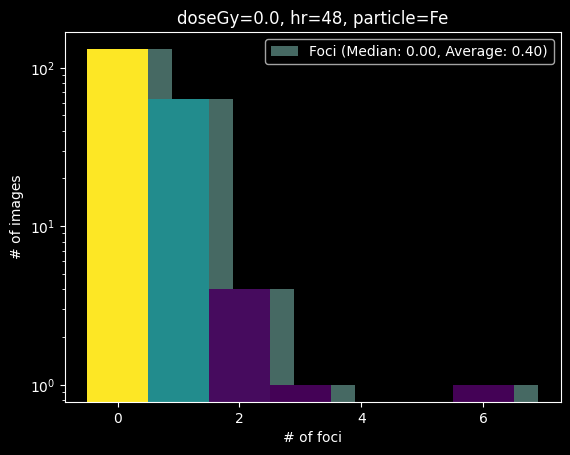

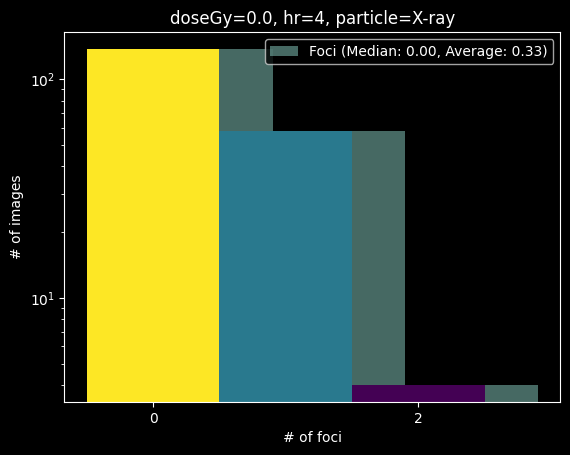

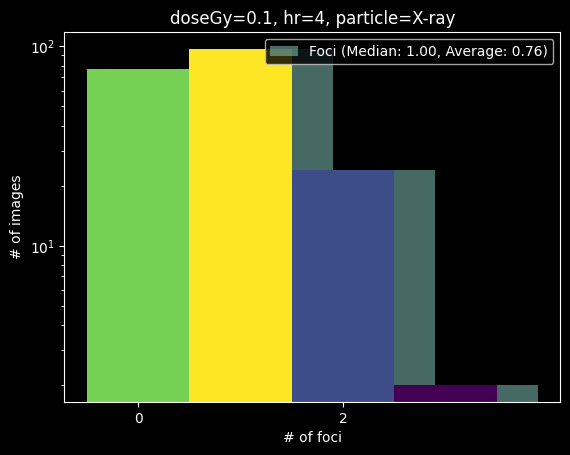

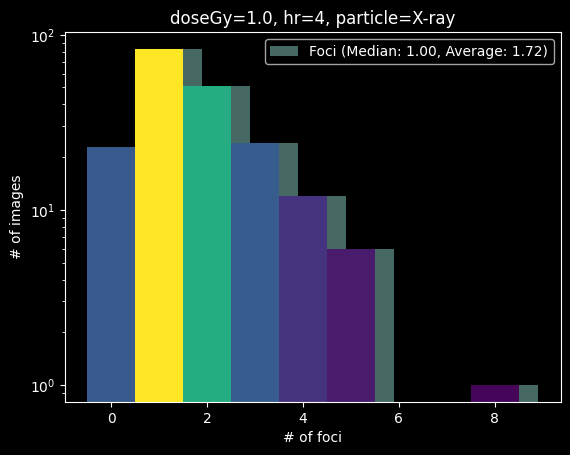

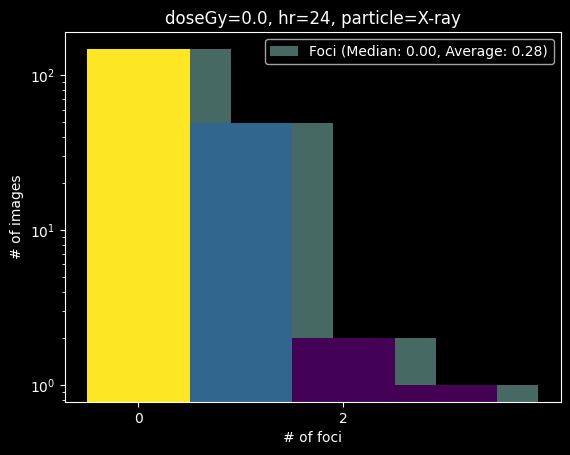

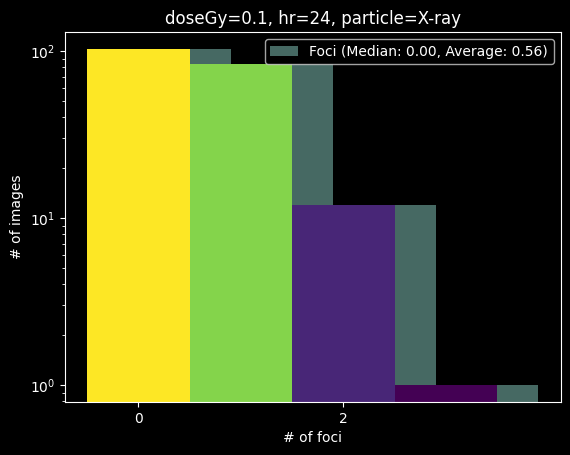

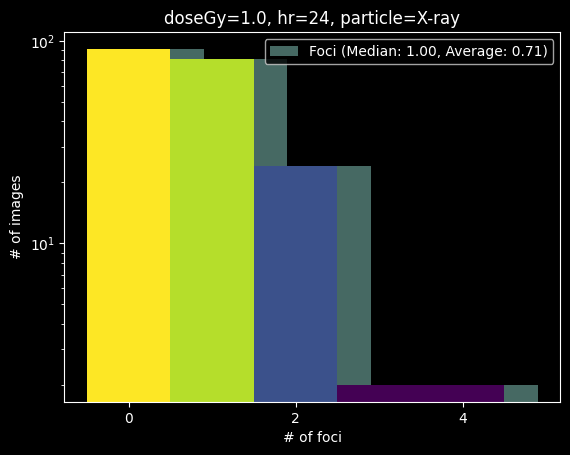

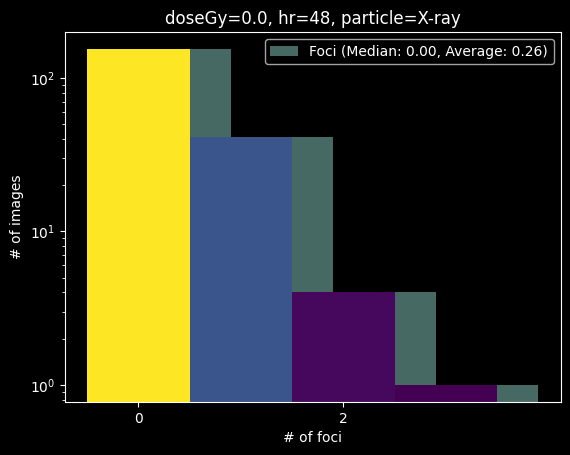

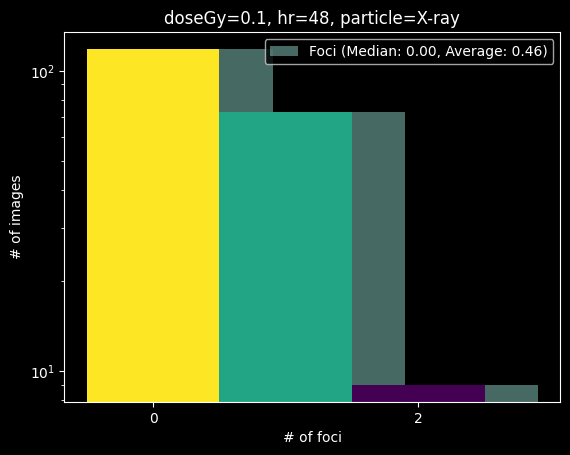

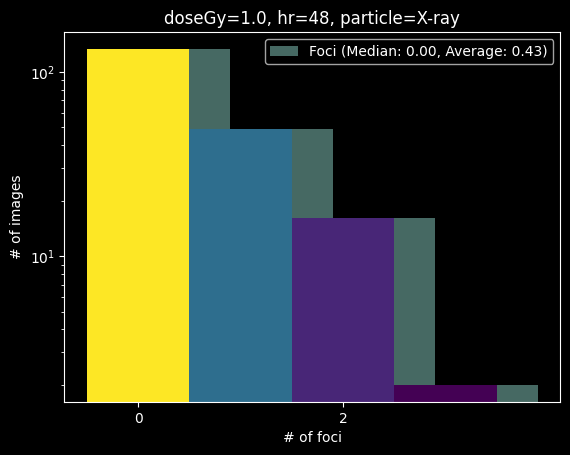

In [26]:
# Create histogram for each condition
for key in foci_count:
    heights, bins, _ = plt.hist(foci_count[key], bins=range(min(foci_count[key]), max(foci_count[key]) + 2), alpha=0.5, label="Foci", rwidth=0.8)

    # Create a colormap
    colormap = plt.cm.viridis

    # Normalize the heights to range from 0 to 1
    norm = plt.Normalize(vmin=heights.min(), vmax=heights.max())

    # Create a list of colors based on the normalized heights
    colors = [colormap(norm(height)) for height in heights]

    # Plot the histogram with colored bars
    plt.bar(bins[:-1], heights, color=colors, width=np.diff(bins))
    
    plt.xticks(range(min(foci_count[key]), max(foci_count[key]) + 1, 2))
    plt.xlabel("# of foci")
    plt.ylabel("# of images")

    # Adjust y-axis scale to logarithmic
    plt.yscale('log')
    
    # Calculate median and average
    median_val = np.median(foci_count[key])
    average_val = np.mean(foci_count[key])

    # Create custom legend labels with median and average information
    legend_label = f"Foci (Median: {median_val:.2f}, Average: {average_val:.2f})"
    plt.legend([legend_label], loc="upper right") 

    # Split key by comma
    key = str(key).split(", ")
    dose = key[0][1:]
    hr = key[1]
    particle = key[2][1:-2]
    fileName = f"dose_{dose}hr_{hr}particle_{particle}"

    plt.title(f"doseGy={dose}, hr={hr}, particle={particle}")

    # Save plots into notebooks/foci_count
    plt.savefig(str(root / "notebooks/foci_count_blob" / fileName) + ".png")
    plt.show()
    plt.close()

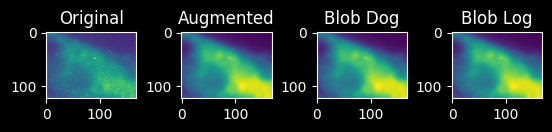

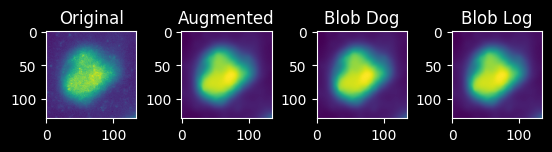

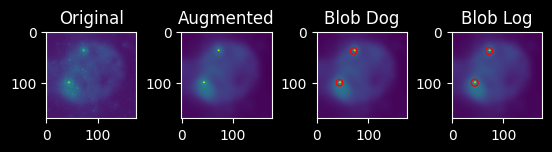

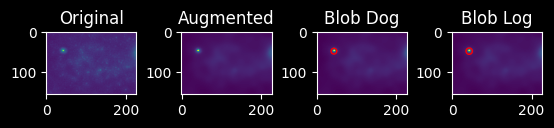

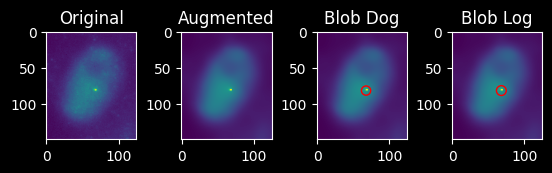

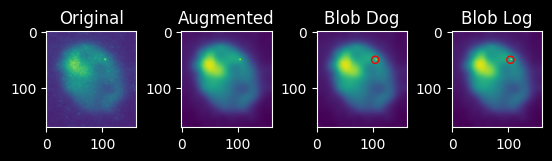

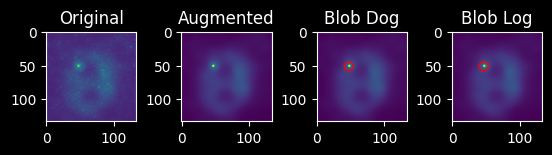

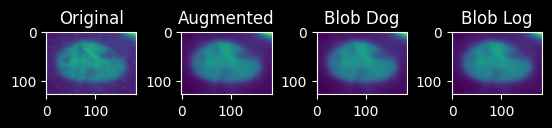

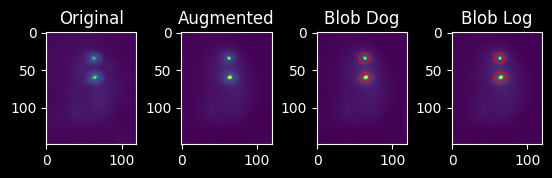

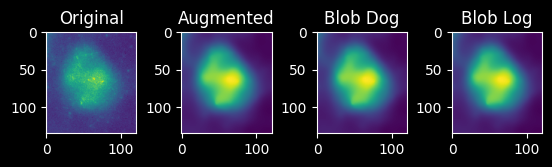

In [34]:
for i in range(10):
    img_key = data_path / data_lists[(1.0, 24, 'X-ray')][i]

    # Load the image using PIL
    img = Image.open(img_key)
    img_array = np.array(img)

    # Normalize the pixel values to the range of 0-255
    image_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))

    # Denoise the normalized image using TVD algorithm
    denoised_array = denoise_tv_chambolle(image_normalized, weight=0.1)

    # Convert the denoised array back to PIL Image and adjust back to 8-bit range
    denoised_image = Image.fromarray(img_as_ubyte(denoised_array))

    # Apply a sharpening filter
    sharpened_image = denoised_image.filter(ImageFilter.UnsharpMask(radius=20, percent=200, threshold=90))
    sharpened_image = np.array(sharpened_image)

    # Denoise the sharpened image using TVD algorithm
    denoised_array = denoise_tv_chambolle(sharpened_image, weight=0.1)
    denoised_image = Image.fromarray(denoised_array)
    denoised_image = np.array(denoised_image)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    ax1.imshow(img)
    ax1.set_title("Original")
    ax2.imshow(denoised_image)
    ax2.set_title("Augmented")
    ax3.imshow(denoised_image)
    ax3.set_title("Blob Dog")
    ax4.imshow(denoised_image)
    ax4.set_title("Blob Log")

    blobs = blob_dog(denoised_image, max_sigma=3.5, min_sigma=1, threshold=0.1, threshold_rel=0.8, overlap=0.5, exclude_border=20)
    blobs2 = blob_log(denoised_image, max_sigma=3.5, min_sigma=1, threshold=0.1, threshold_rel=0.8, overlap=0.5, exclude_border=20)

    # Compute radii in the 3rd column.
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2) + 5
    blobs2[:, 2] = blobs2[:, 2] * np.sqrt(2) + 5
    
    for blob in blobs:
        y, x, area = blob
        ax3.add_patch(plt.Circle((x, y), area, color='r', fill=False))

    for blob in blobs2:
        y, x, area = blob
        ax4.add_patch(plt.Circle((x, y), area, color='r', fill=False))

    # Export figure to notebooks/foci_count
    plt.savefig(str(root / "notebooks/foci_count_blob" / f"sample_{i}") + ".png")

    plt.show()